# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.343074
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *The weights are initialized randomly, making the predicted labels a random guess of the correct class out ot 10 classes. Therefore, theoretically, the cross-entropy loss should be -log(1/10)* 



In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.734879 analytic: 2.734879, relative error: 1.326160e-08
numerical: 2.809322 analytic: 2.809321, relative error: 3.803260e-08
numerical: -2.284485 analytic: -2.284485, relative error: 1.312962e-08
numerical: 1.991765 analytic: 1.991765, relative error: 6.882601e-08
numerical: 0.536473 analytic: 0.536473, relative error: 1.086492e-07
numerical: -1.256510 analytic: -1.256511, relative error: 3.177133e-08
numerical: -1.123837 analytic: -1.123837, relative error: 3.475950e-08
numerical: -2.810509 analytic: -2.810509, relative error: 1.399677e-08
numerical: -0.965149 analytic: -0.965149, relative error: 3.012842e-08
numerical: 1.018921 analytic: 1.018921, relative error: 8.197094e-08
numerical: -0.555360 analytic: -0.555360, relative error: 8.670534e-08
numerical: -2.519403 analytic: -2.519403, relative error: 2.237383e-08
numerical: 3.182056 analytic: 3.182056, relative error: 1.816461e-08
numerical: -0.937591 analytic: -0.937591, relative error: 6.127111e-08
numerical: 0.82109

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.343074e+00 computed in 0.072626s
vectorized loss: 2.343074e+00 computed in 0.004775s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = 0
best_softmax = None

# hyperparem
learning_rates = np.array([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
regularization_strengths = np.append([1,5], np.arange(10,100,20))
regularization_strengths = np.append(regularization_strengths, np.arange(100,1000,100))
print('learning_rates: ', learning_rates)
print('regularization_strengths: ', regularization_strengths)

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


num_lr = learning_rates.shape[0]
num_reg = regularization_strengths.shape[0]
num_iters = 1500
loss_hist_val = np.zeros((num_lr*num_reg, num_iters))
counter = 0  # initialize counter

for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()  # define a new object of class: Softmax
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg, 
                          num_iters=num_iters, batch_size=200, verbose=False)
        
        # keep trace of hyperparameters tunning
        loss_hist_val[counter, :] = loss_hist
        counter += 1
        
        # predict labels on training and validation set
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        print('learning_rate: %e, reg: %d' % (lr,reg))
        print('             training accuracy: %f' % (train_accuracy, ))
        print('             validation accuracy: %f' % (val_accuracy, ))
        
        # update the best parameters and save the best softmax classifier
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_setting = (lr,reg)
            best_softmax = deepcopy(softmax) # copy an instance of class
        
        # save result
        key = (lr,reg)
        results[key] = (train_accuracy, val_accuracy)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    

learning_rates:  [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
regularization_strengths:  [  1   5  10  30  50  70  90 100 200 300 400 500 600 700 800 900]
learning_rate: 1.000000e-08, reg: 1
             training accuracy: 0.161796
             validation accuracy: 0.155000
learning_rate: 1.000000e-08, reg: 5
             training accuracy: 0.154082
             validation accuracy: 0.163000
learning_rate: 1.000000e-08, reg: 10
             training accuracy: 0.140816
             validation accuracy: 0.148000
learning_rate: 1.000000e-08, reg: 30
             training accuracy: 0.164347
             validation accuracy: 0.172000
learning_rate: 1.000000e-08, reg: 50
             training accuracy: 0.158041
             validation accuracy: 0.159000
learning_rate: 1.000000e-08, reg: 70
             training accuracy: 0.149735
             validation accuracy: 0.146000
learning_rate: 1.000000e-08, reg: 90
             training accuracy: 0.175306
             validation accura

learning_rate: 1.000000e-04, reg: 30
             training accuracy: 0.263163
             validation accuracy: 0.246000


/home/vincent/stanford_cs231n/assignment1/cs231n/classifiers/softmax.py:85: RuntimeWarning: divide by zero encountered in log
  correct_logprobs = -np.log(probs[range(num_train), y])


learning_rate: 1.000000e-04, reg: 50
             training accuracy: 0.268510
             validation accuracy: 0.283000
learning_rate: 1.000000e-04, reg: 70
             training accuracy: 0.209918
             validation accuracy: 0.215000
learning_rate: 1.000000e-04, reg: 90
             training accuracy: 0.259490
             validation accuracy: 0.261000
learning_rate: 1.000000e-04, reg: 100
             training accuracy: 0.232898
             validation accuracy: 0.217000
learning_rate: 1.000000e-04, reg: 200
             training accuracy: 0.253714
             validation accuracy: 0.257000
learning_rate: 1.000000e-04, reg: 300
             training accuracy: 0.198939
             validation accuracy: 0.181000
learning_rate: 1.000000e-04, reg: 400
             training accuracy: 0.205469
             validation accuracy: 0.193000
learning_rate: 1.000000e-04, reg: 500
             training accuracy: 0.223429
             validation accuracy: 0.245000
learning_rate: 1.000000e-04

/home/vincent/stanford_cs231n/assignment1/cs231n/classifiers/softmax.py:84: RuntimeWarning: invalid value encountered in true_divide
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


learning_rate: 1.000000e-03, reg: 1
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 1.000000e-03, reg: 5
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 1.000000e-03, reg: 10
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 1.000000e-03, reg: 30
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 1.000000e-03, reg: 50
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 1.000000e-03, reg: 70
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 1.000000e-03, reg: 90
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 1.000000e-03, reg: 100
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 1.000000e-03, reg:

In [7]:
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %d train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-08 reg 1 train accuracy: 0.161796 val accuracy: 0.155000
lr 1.000000e-08 reg 5 train accuracy: 0.154082 val accuracy: 0.163000
lr 1.000000e-08 reg 10 train accuracy: 0.140816 val accuracy: 0.148000
lr 1.000000e-08 reg 30 train accuracy: 0.164347 val accuracy: 0.172000
lr 1.000000e-08 reg 50 train accuracy: 0.158041 val accuracy: 0.159000
lr 1.000000e-08 reg 70 train accuracy: 0.149735 val accuracy: 0.146000
lr 1.000000e-08 reg 90 train accuracy: 0.175306 val accuracy: 0.174000
lr 1.000000e-08 reg 100 train accuracy: 0.159592 val accuracy: 0.161000
lr 1.000000e-08 reg 200 train accuracy: 0.176408 val accuracy: 0.171000
lr 1.000000e-08 reg 300 train accuracy: 0.160918 val accuracy: 0.160000
lr 1.000000e-08 reg 400 train accuracy: 0.151367 val accuracy: 0.154000
lr 1.000000e-08 reg 500 train accuracy: 0.152224 val accuracy: 0.146000
lr 1.000000e-08 reg 600 train accuracy: 0.147061 val accuracy: 0.155000
lr 1.000000e-08 reg 700 train accuracy: 0.155633 val accuracy: 0.151000
l

In [8]:
# sanity check: 
# - softmax is the last classifier in parameters tunning
# - best_softmax is the besr classifier
if np.array_equal(best_softmax.W, softmax.W):
    print('Warning: Maybe something is wrong. The last classifier is the best?')
else:
    print('Should be fine. Check the info of the best softmax:')
print('W:')
print(best_softmax.W)
best_train_accu, best_val_accu = results[(best_setting[0], best_setting[1])]
print('lr %e reg %d train accuracy: %f val accuracy: %f' % (
    best_setting[0], best_setting[1], best_train_accu, best_val_accu))

Should be fine. Check the info of the best softmax:
W:
[[-1.98472507e-04 -1.40148710e-04 -3.82911268e-04 ... -2.38964746e-06
   8.53041881e-05  4.91097179e-04]
 [-1.36405130e-04 -1.53762925e-04 -1.19079207e-05 ...  1.23187594e-04
   1.70842442e-04  1.12068223e-04]
 [ 1.03833621e-04 -2.36970247e-04 -5.43946757e-04 ...  3.72072954e-05
   1.24347962e-04 -1.43975580e-04]
 ...
 [ 8.23769571e-05 -4.01088852e-04  1.73784150e-04 ...  2.01115567e-04
  -5.42748113e-04  3.66496114e-04]
 [-3.24841716e-04 -5.33542862e-06 -1.06118962e-04 ... -1.48681954e-04
   1.69535960e-04  4.13766997e-04]
 [-1.39902442e-04 -1.06620024e-04  5.63043262e-05 ... -4.64580779e-04
  -2.73334524e-04 -9.35290294e-05]]
lr 1.000000e-06 reg 900 train accuracy: 0.400041 val accuracy: 0.404000


In [9]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.395000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$
True

$\color{blue}{\textit Your Explanation:}$
- For SVM loss, only the positive margins (>0) are added into loss. Therefore, if the new-coming data output all-negative margins, then the SVM loss is not changed.
- For Softmax loss (cross-entropy loss), when a new datapoint is added, the loss *-log(correct_class_probability)* is always added into loss. Since *correct_class_probability* is always within range [0,1], then  *-log(correct_class_probability)* is alway positive


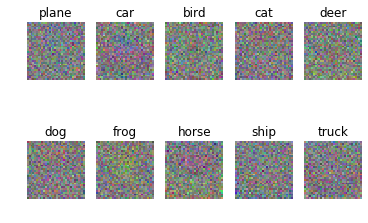

In [10]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])